# Imports

In [93]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import matplotlib.dates as mdates
import statistics
import sharedVariables
from sharedVariables import *

In [200]:
# Datasets
dataset_sources = {
    'baseline': 'data\\20210919-16-baseline',
    'syncmesh': 'data\\20210910-syncmesh-gzip',
    # 'advanced': 'data\\20210917-advanced'
    'advanced': 'data\\20210919-15'
}


In [201]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

In [202]:
ip_seperator

'92.60.39.199'

In [204]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[(df["tcp.dstport"] == 443)] #  | (df["tcp.srcport"] == 443)
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    df = df[(df["tcp.dstport"] != 22) & (df["tcp.srcport"] != 22)]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith("10"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)
            # print(len(currentdf))

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True,subset=['ip.src', 'ip.dst'])

            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    df_base = filterDataForLocalTraffic(df_base)
    return (df_base, timings)

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])
    
datasets["advanced"][1]

c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-16-baseline\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-16-baseline\10.1.0.2.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-16-baseline\10.1.0.3.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-16-baseline\10.2.0.12.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-16-baseline\10.3.0.13.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.1.0.2.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.2.0.12.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.3.0.13.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-15\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210919-15\10.1.0.2.pcap.csv
c:

array(['2021-09-19T13:09:02.887562000', '2021-09-19T13:12:18.471713000',
       '2021-09-19T13:15:33.615445000', '2021-09-19T13:18:48.783684000',
       '2021-09-19T13:22:04.407796000', '2021-09-19T13:25:23.064087000',
       '2021-09-19T13:28:41.932008000', '2021-09-19T13:32:00.699693000',
       '2021-09-19T13:35:19.236315000'], dtype='datetime64[ns]')

In [205]:
df = datasets["advanced"][0]
df[(df['ip.src']=='10.1.0.11') & (df['ip.dst']=='10.2.0.12')]
# df[(df['ip.src']=='10.1.0.11')]

,tcp.analysis.initial_rtt,ip.id,ip.src,ip.dst,ip.len,tcp.srcport,tcp.dstport
frame.time_epoch,,,,,,,
2021-09-19 13:04:58.002909,NaN,0x00008da8,10.1.0.11,10.2.0.12,617.0,54938.0,27017.0
2021-09-19 13:04:58.307110,NaN,0x00008da9,10.1.0.11,10.2.0.12,52.0,54938.0,27017.0
2021-09-19 13:04:58.307424,NaN,0x00008daa,10.1.0.11,10.2.0.12,412.0,54938.0,27017.0
2021-09-19 13:04:58.307637,NaN,0x000002de,10.1.0.11,10.2.0.12,550.0,27017.0,50226.0
2021-09-19 13:04:58.458302,NaN,0x000002df,10.1.0.11,10.2.0.12,514.0,27017.0,50226.0
...,...,...,...,...,...,...,...
2021-09-19 13:36:21.160751,NaN,0x000096fa,10.1.0.11,10.2.0.12,532.0,54938.0,27017.0
2021-09-19 13:36:21.311106,NaN,0x000096fb,10.1.0.11,10.2.0.12,419.0,54938.0,27017.0
2021-09-19 13:36:21.469484,NaN,0x000096fc,10.1.0.11,10.2.0.12,482.0,54938.0,27017.0


In [206]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))

    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # print(df[df['ip.src']==combination[0] & df['ip.dst']==combination[1]])
        # Use both src_ip and dest_ip as they are not request related
        key = "between " + combination[0] + " and " + combination[1]
        betweenNodesDataset[key] = df[((df['ip.src']==str(combination[0])) & (df['ip.dst']==str(combination[1]))) | ((df['ip.src']==str(combination[1])) & (df['ip.dst']==str(combination[0])))]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

setname = "advanced"
for key in node_datasets[setname]:
    print(key, ":", len(node_datasets[setname][key]))
    # print(node_datasets[setname][key])
    

between 10.1.0.4 and 10.1.0.11 : 25243
between 10.1.0.4 and 10.3.0.13 : 21392
between 10.1.0.4 and 10.1.0.3 : 4092
between 10.1.0.4 and 10.2.0.12 : 20513
between 10.1.0.4 and 10.1.0.2 : 0
between 10.1.0.11 and 10.3.0.13 : 25952
between 10.1.0.11 and 10.1.0.3 : 3588
between 10.1.0.11 and 10.2.0.12 : 25829
between 10.1.0.11 and 10.1.0.2 : 0
between 10.3.0.13 and 10.1.0.3 : 3575
between 10.3.0.13 and 10.2.0.12 : 4151
between 10.3.0.13 and 10.1.0.2 : 0
between 10.1.0.3 and 10.2.0.12 : 3533
between 10.1.0.3 and 10.1.0.2 : 14656
between 10.2.0.12 and 10.1.0.2 : 0


In [207]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    print(key)
    print(datasets[key][1])
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "baseline"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


baseline
['2021-09-19T16:01:40.956717000' '2021-09-19T16:01:41.961412000'
 '2021-09-19T16:01:43.977425000' '2021-09-19T16:01:48.201414000'
 '2021-09-19T16:01:56.393421000' '2021-09-19T16:02:12.521415000'
 '2021-09-19T16:02:46.057411000' '2021-09-19T16:07:15.339943000'
 '2021-09-19T16:07:16.361412000' '2021-09-19T16:07:18.377428000'
 '2021-09-19T16:07:22.537431000' '2021-09-19T16:07:30.729405000'
 '2021-09-19T16:07:46.857401000' '2021-09-19T16:08:19.881424000'
 '2021-09-19T16:12:56.217501000' '2021-09-19T16:12:57.225431000'
 '2021-09-19T16:12:59.241460000' '2021-09-19T16:13:03.273418000'
 '2021-09-19T16:13:11.465411000' '2021-09-19T16:13:27.593430000'
 '2021-09-19T16:13:59.849433000' '2021-09-19T16:18:42.045581000'
 '2021-09-19T16:18:43.049435000' '2021-09-19T16:18:45.065436000'
 '2021-09-19T16:18:49.129417000' '2021-09-19T16:18:57.321406000'
 '2021-09-19T16:19:13.449401000' '2021-09-19T16:19:45.961448000'
 '2021-09-19T16:24:41.741501000' '2021-09-19T16:24:42.761428000'
 '2021-09-19T16:

C:\Users\danie\AppData\Local\Temp/ipykernel_25008/1003008133.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])


syncmesh
['2021-09-10T17:48:48.864056000' '2021-09-10T17:49:20.144149000'
 '2021-09-10T17:50:10.244489000' '2021-09-10T17:51:08.412226000'
 '2021-09-10T17:52:29.420688000' '2021-09-10T17:52:59.909948000'
 '2021-09-10T17:53:47.364877000' '2021-09-10T17:54:40.965647000'
 '2021-09-10T17:55:53.408539000']
advanced
['2021-09-19T13:09:02.887562000' '2021-09-19T13:12:18.471713000'
 '2021-09-19T13:15:33.615445000' '2021-09-19T13:18:48.783684000'
 '2021-09-19T13:22:04.407796000' '2021-09-19T13:25:23.064087000'
 '2021-09-19T13:28:41.932008000' '2021-09-19T13:32:00.699693000'
 '2021-09-19T13:35:19.236315000']
collect1 : 0
collect7 : 0
collect14 : 0
collect30 : 0
aggregate1 : 0
aggregate7 : 0
aggregate14 : 10
aggregate30 : 0


10.1.0.4 10.1.0.11
Server
Config Node 1
10.1.0.4 10.3.0.13
Server
Config Node 3
10.1.0.3 10.1.0.4
Server Server
Config
10.1.0.4 10.2.0.12
Server
Config Node 2
10.1.0.11 10.3.0.13
Node 1 Node 3
10.1.0.3 10.1.0.11
Server Node 1
10.1.0.11 10.2.0.12
Node 1 Node 2
10.1.0.3 10.3.0.13
Server Node 3
10.3.0.13 10.2.0.12
Node 3 Node 2
10.1.0.3 10.2.0.12
Server Node 2
10.1.0.2 10.1.0.3
Client Server


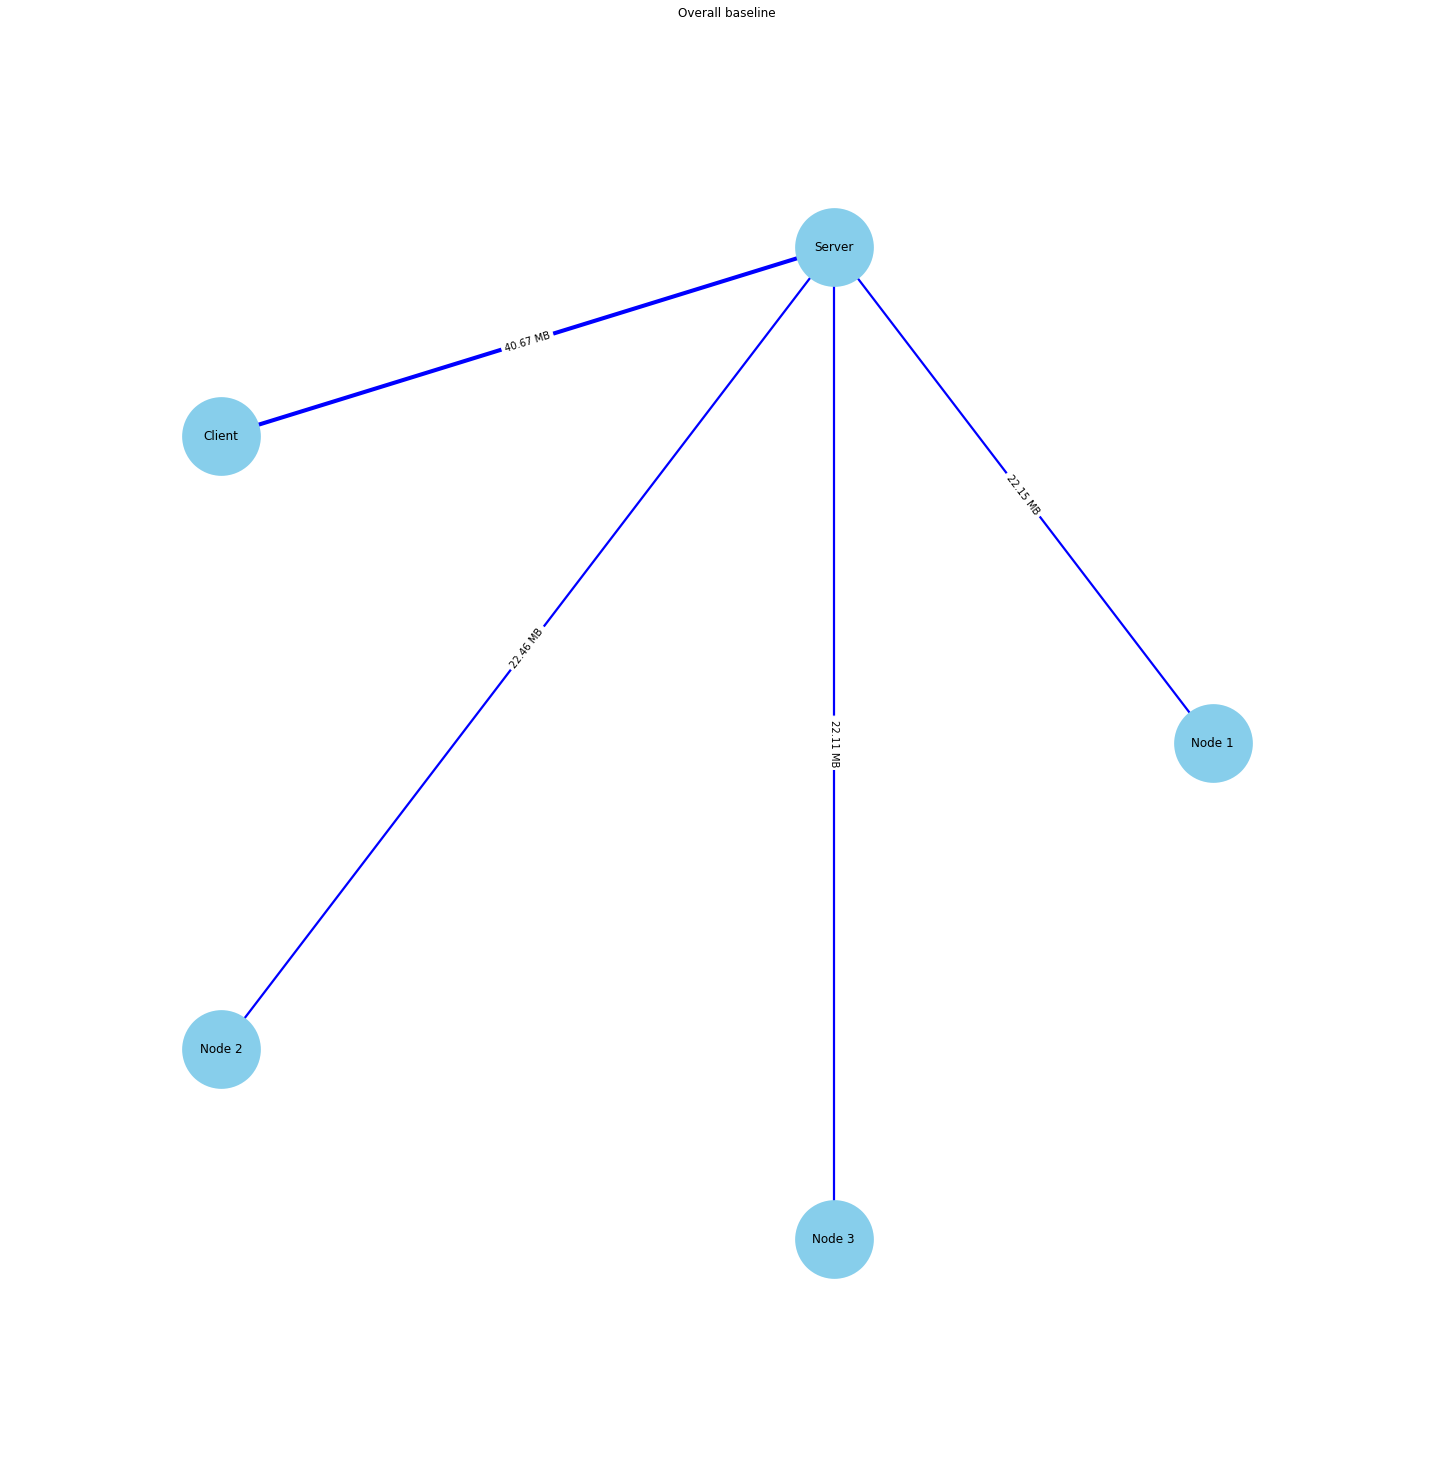

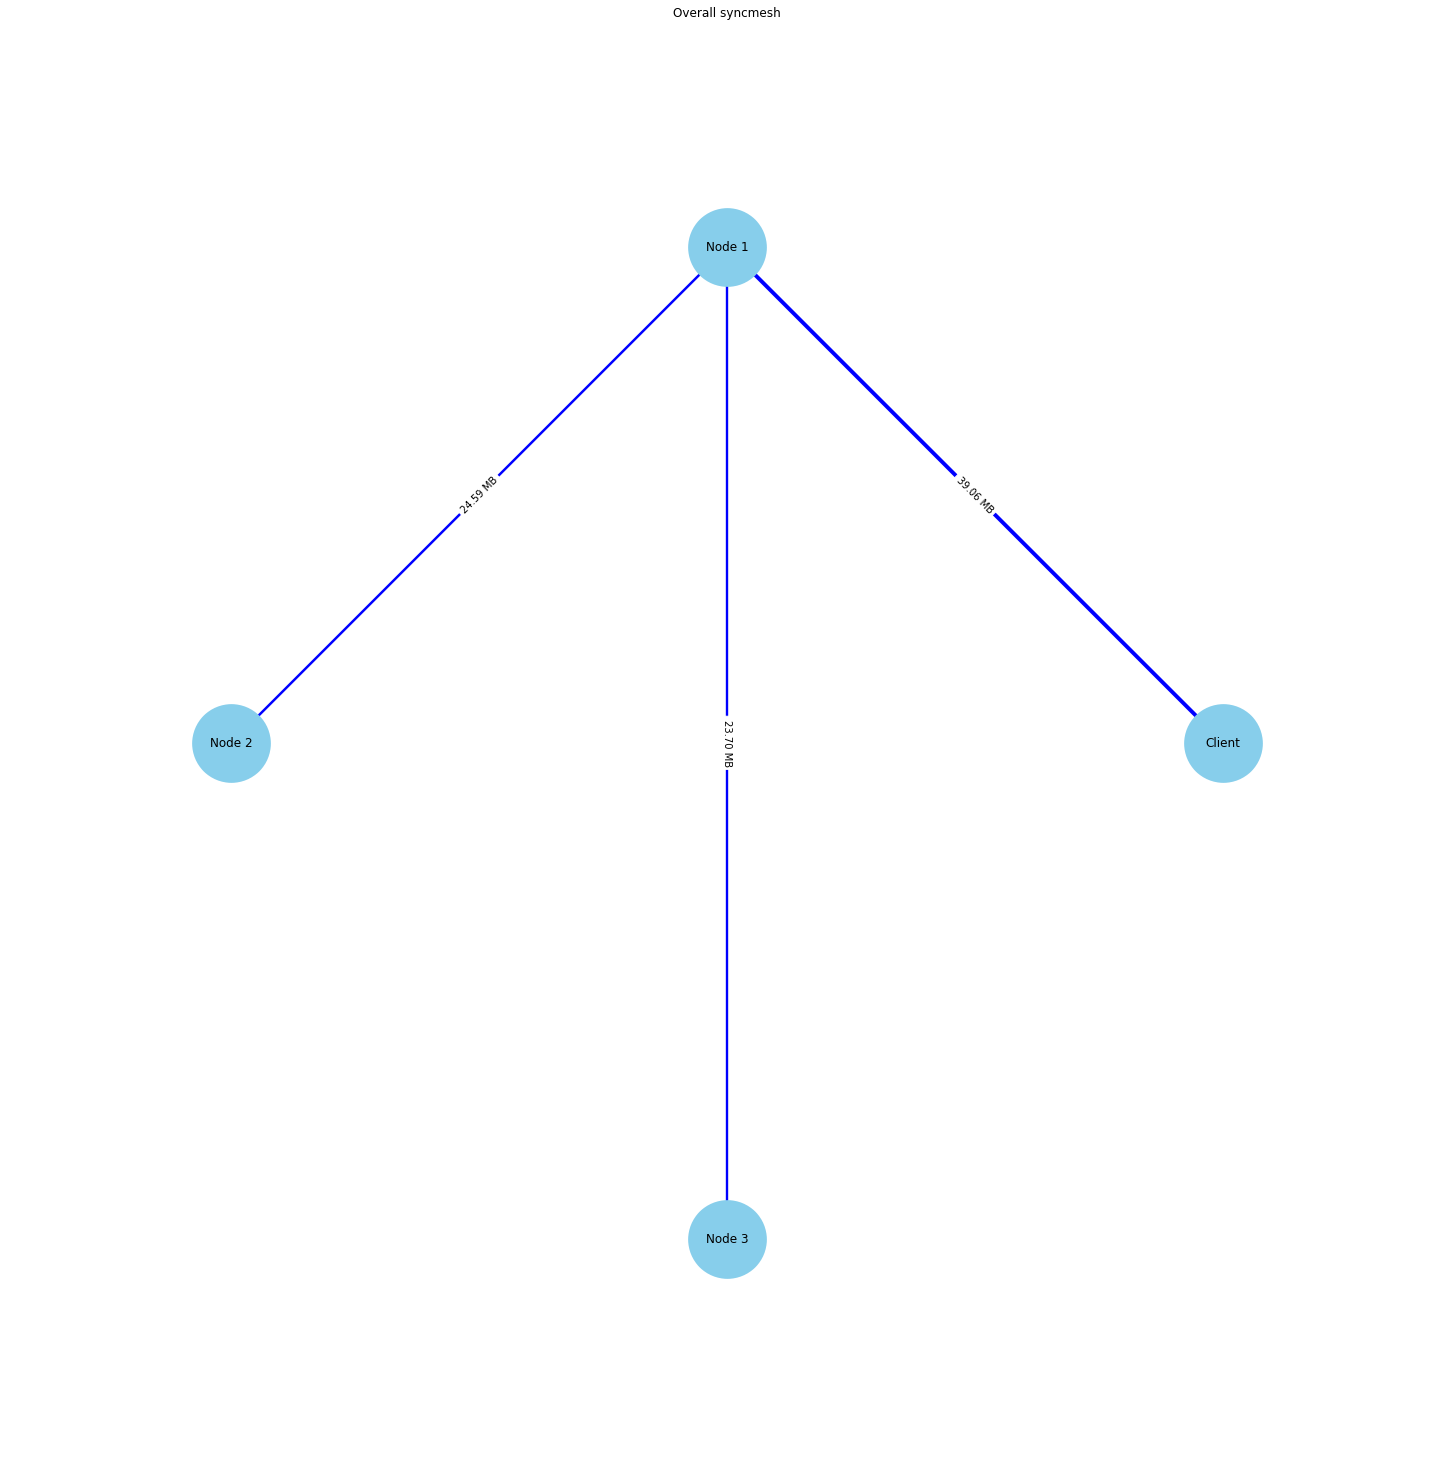

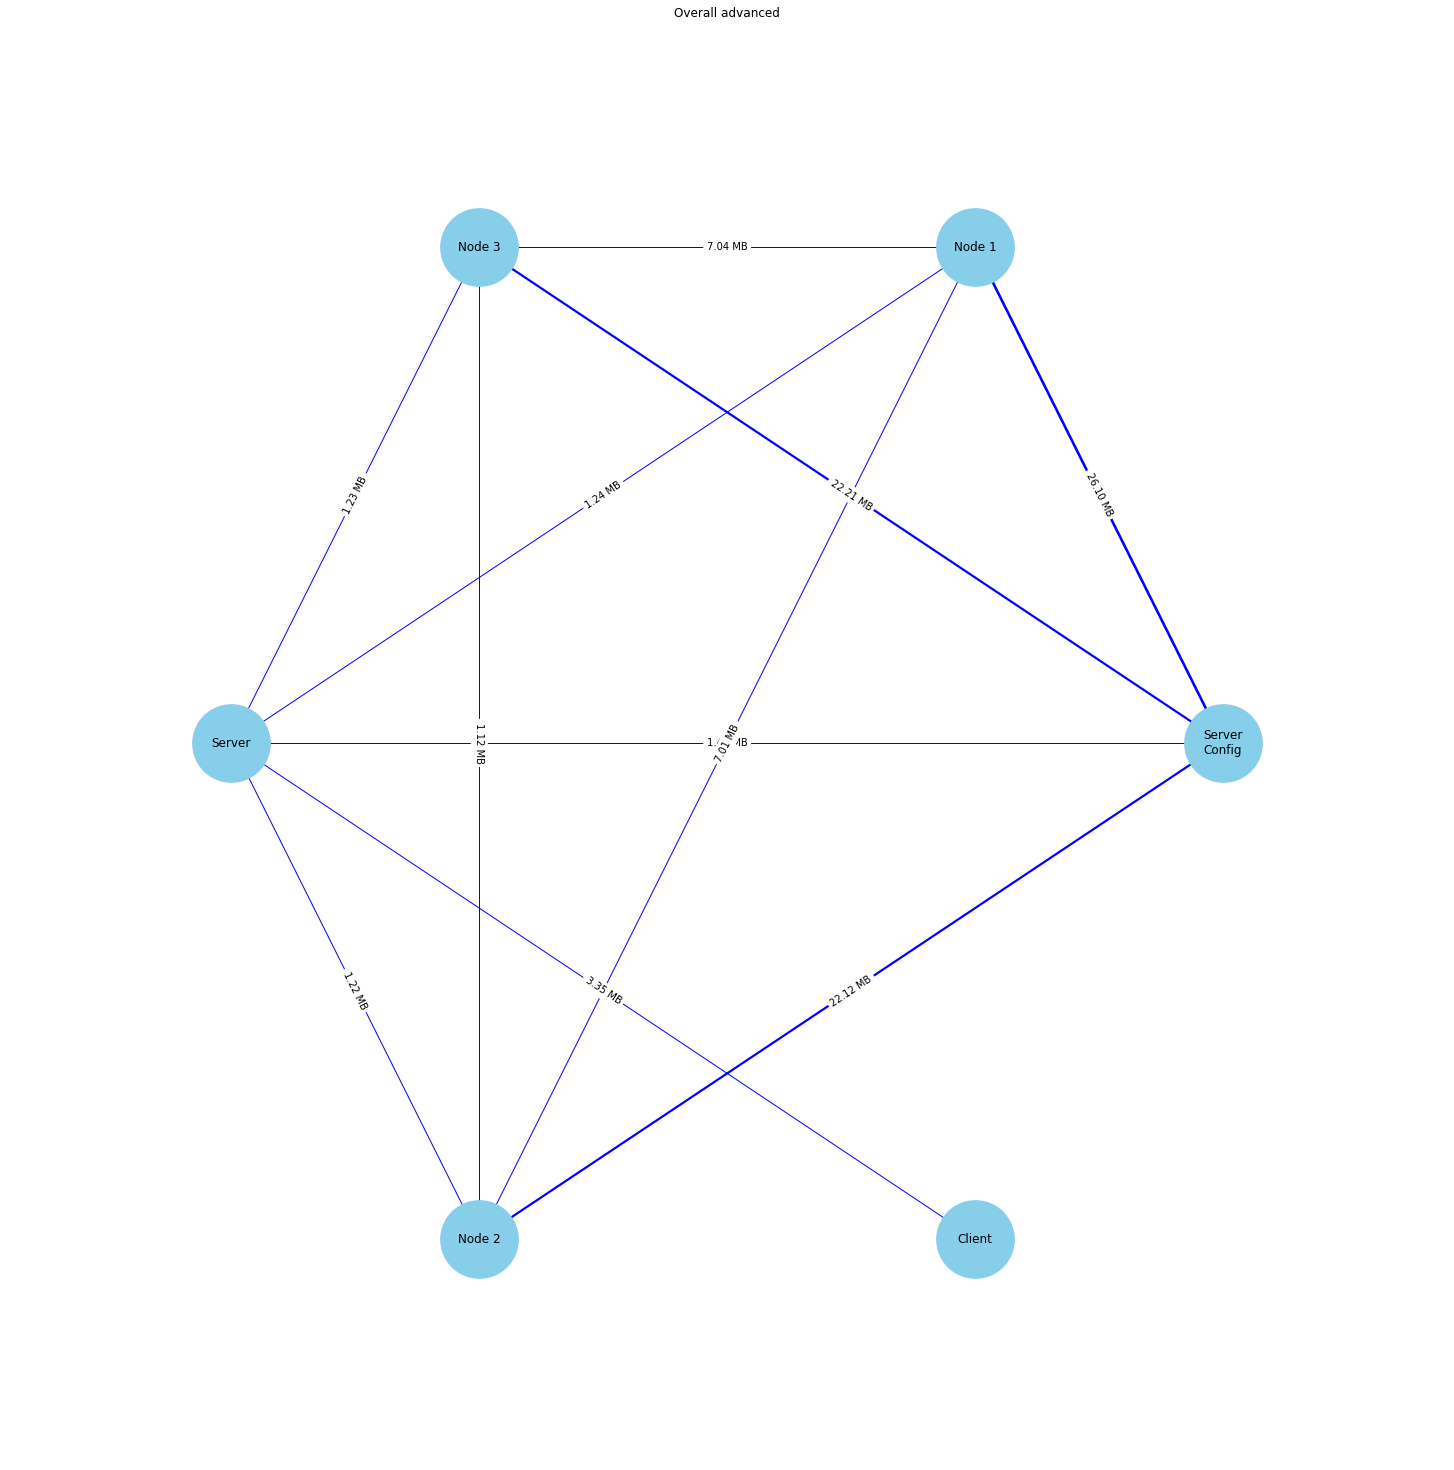

In [208]:
def get_node_name(ip):
    if(ip == "10.1.0.2"):
        return "Client"
    elif(ip == "10.1.0.3"):
        return "Server"
    elif(ip == "10.1.0.4"):
        return "Server\nConfig"
    elif(ip == "10.1.0.255"):
        return "ORCHESTRATOR"
    elif(ip.startswith("10.")):
        return "Node " + ip.split(".")[1]
    return ip

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        if len(subset["ip.dst"]) > 0:

            if subset_key == "advanced":
                # print(node_dataset_key) 
                print(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0]) 
                print(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]))
            G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=np.clip(subset["ip.len"].sum()/10000000, 1, 1000), label=to_human_readable(subset["ip.len"].sum()))

    pos = nx.circular_layout(G)

    size =20
    plt.figure(index+1,figsize=(size,size))
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.savefig("out/network_"+subset_key+".png")
    

plt.show()

In [209]:
node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

KeyError: 'between 10.1.0.3 and 10.1.0.2'

collect1
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
collect7
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
collect14
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
collect30
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
aggregate1
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
aggregate7
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
aggregate14
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
between 10.1.0.3 and 10.2.0.12
between 10.1.0.3 and 10.3.0.13
aggregate30
between 10.1.0.11 and 10.1.0.3
between 10.1.0.3 and 10.

C:\Users\danie\AppData\Local\Temp/ipykernel_25008/1301179033.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(int(str(index)+str(e_index)))


aggregate7
between 10.3.0.13 and 10.1.0.11
between 10.3.0.13 and 10.2.0.12
between 10.3.0.13 and 10.1.0.4
between 10.3.0.13 and 10.1.0.3
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.1.0.4
between 10.1.0.11 and 10.1.0.3
between 10.2.0.12 and 10.1.0.4
between 10.2.0.12 and 10.1.0.3
between 10.1.0.4 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
aggregate14
between 10.1.0.4 and 10.1.0.11
between 10.1.0.4 and 10.2.0.12
between 10.1.0.4 and 10.3.0.13
between 10.1.0.4 and 10.1.0.3
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.1.0.3
between 10.2.0.12 and 10.3.0.13
between 10.2.0.12 and 10.1.0.3
between 10.3.0.13 and 10.1.0.3
between 10.1.0.3 and 10.1.0.2
aggregate30
between 10.3.0.13 and 10.1.0.11
between 10.3.0.13 and 10.2.0.12
between 10.3.0.13 and 10.1.0.4
between 10.3.0.13 and 10.1.0.3
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.1.0.4
between 10.1.0.11 and 10.1.0.3
between 10.2.0.12 and 10.1.0.4
between 10.2.0.12 and 10.1.0.3

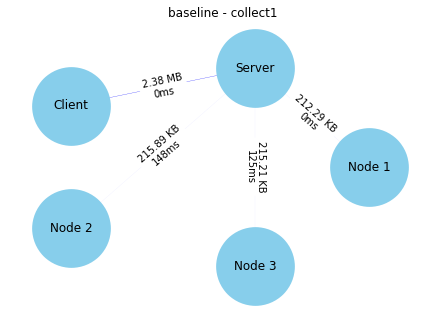

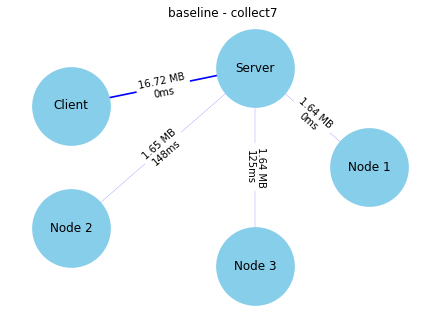

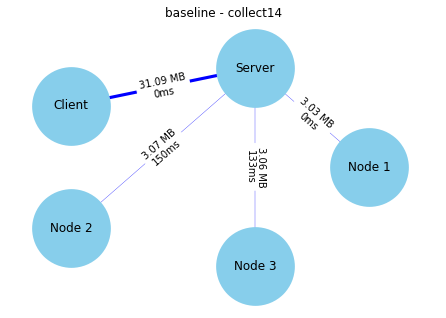

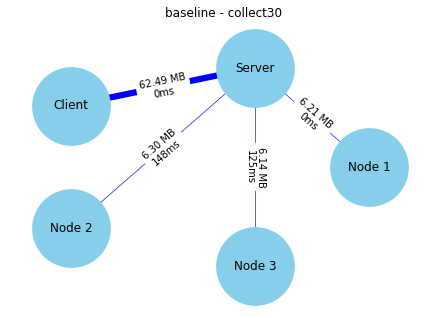

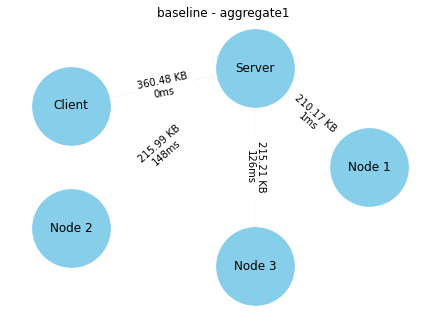

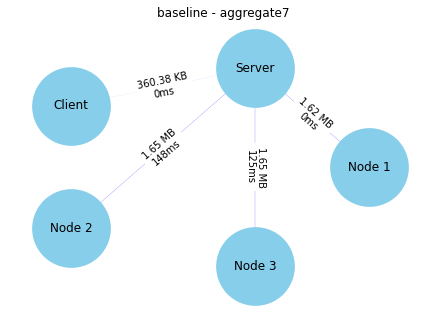

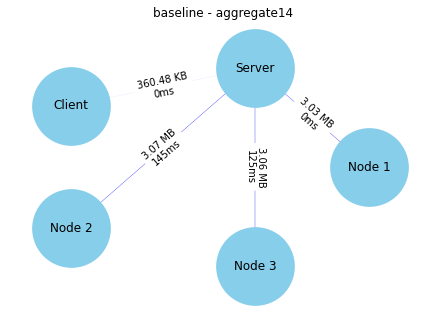

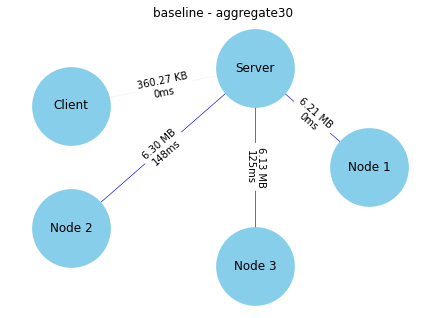

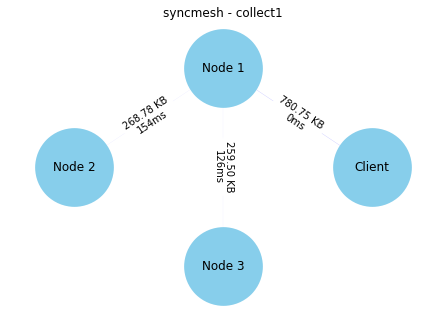

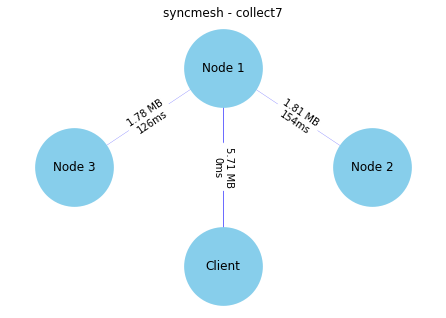

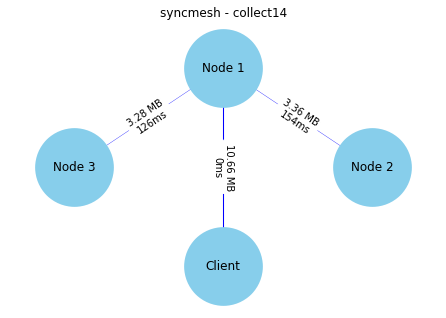

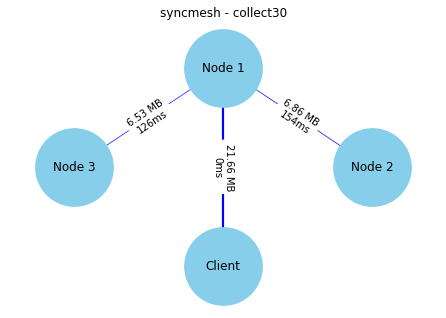

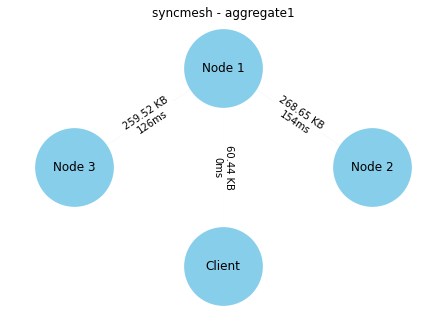

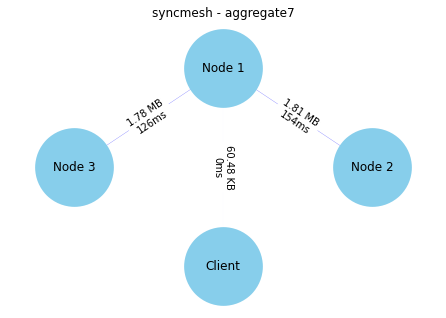

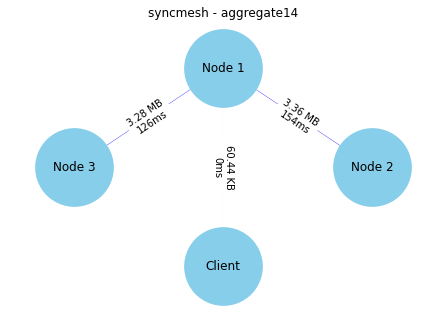

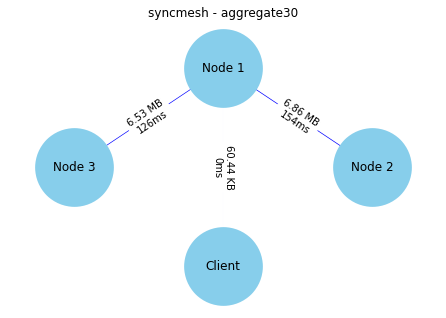

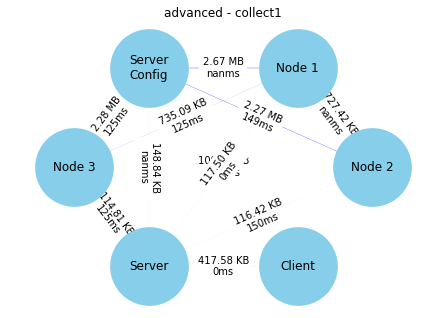

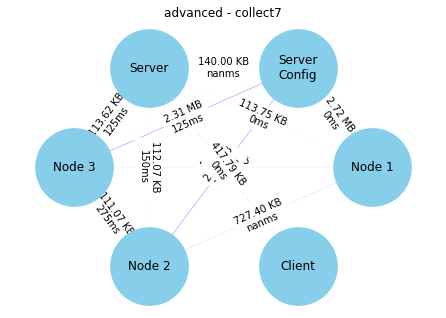

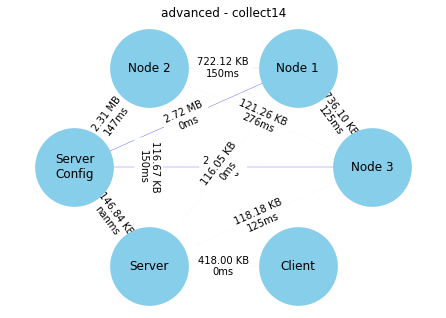

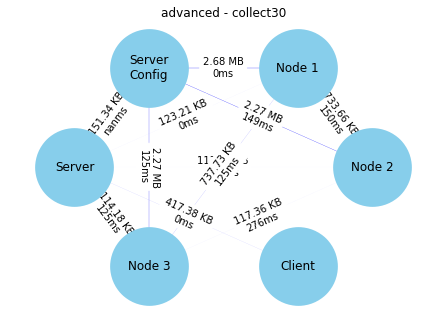

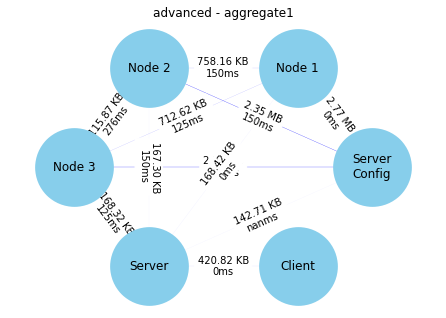

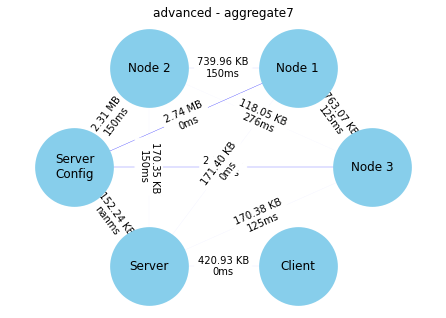

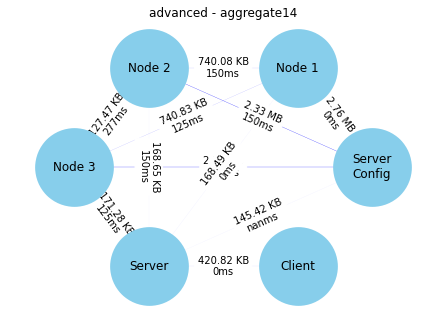

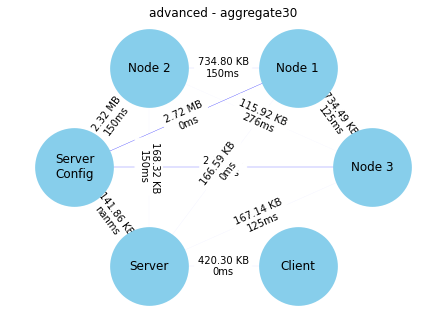

In [ ]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        print(experiment_key)
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            if len(subset["ip.dst"]) > 0:
                print(node_dataset_key) 
                G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()) + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms")
                # print(subset["tcp.analysis.initial_rtt"].mean()* 1000)

        pos = nx.circular_layout(G)

        plt.figure(int(str(index)+str(e_index)))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        plt.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

# node_experiment_datasets
# plt.show()

In [ ]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


subset_col = []
experiment_group_col = []
experiment_col = []
traffic_col = []
rtt_col = []
print("Aggregated Traffic")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        subset_col.append(subset_key)   
        experiment_group_col.append(experiment_key.translate(remove_digits))
        experiment_col.append(experiment_key)
        sum_bytes = 0
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            sum_bytes = sum_bytes + subset["ip.len"].sum()

        traffic_col.append(sum_bytes)
        print(subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

print("Median RTT")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        rtt = np.array([])
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

        # print(rtt)
        rtt_col.append(np.nanmean(rtt) * 1000)
        print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))

Aggregated Traffic
baseline - collect1: 3.03 MB
baseline - collect7: 21.65 MB
baseline - collect14: 40.24 MB
baseline - collect30: 81.14 MB
baseline - aggregate1: 1.00 MB
baseline - aggregate7: 5.27 MB
baseline - aggregate14: 9.52 MB
baseline - aggregate30: 19.01 MB
syncmesh - collect1: 1.31 MB
syncmesh - collect7: 9.30 MB
syncmesh - collect14: 17.30 MB
syncmesh - collect30: 35.05 MB
syncmesh - aggregate1: 588.61 KB
syncmesh - aggregate7: 3.65 MB
syncmesh - aggregate14: 6.70 MB
syncmesh - aggregate30: 13.46 MB
advanced - collect1: 9.70 MB
advanced - collect7: 9.80 MB
advanced - collect14: 9.85 MB
advanced - collect30: 9.74 MB
advanced - aggregate1: 10.13 MB
advanced - aggregate7: 10.08 MB
advanced - aggregate14: 10.12 MB
advanced - aggregate30: 10.02 MB
Median RTT
baseline - collect1: 68.41452373430826 msec 0.06279779944438046
baseline - collect7: 68.35275518292472 msec 0.06276638854341253
baseline - collect14: 70.80780896322737 msec 0.0664481851398581
baseline - collect30: 68.42436084

In [ ]:
analyze_table = pd.DataFrame(dict(experiment=subset_col,
scenario=experiment_group_col,
                  scenario_nodes=experiment_col,
                  traffic=traffic_col,
                  rtt=rtt_col))



sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
    traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))


sum_table.to_latex('sum_table.tex',)
def our_sort(index):
    print(index)
    # if index.name == "subset":
    print(index)
    return index 



# sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
# sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh'])

extra_table = sum_table.copy()
extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

for scenario in ["aggregate", "collect"]:
    extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
    extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_human_readable(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
extra_extra_table = extra_table.columns.str.split('.', expand=True)

extra_table.columns = extra_extra_table

extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
extra_table.to_latex("sum_table.tex")
extra_table
# print([tuple(col.split("%")) for col in sum_table.columns.values])


Traffic (in MB)                    RTT (in ms)              
                 aggregate          collect     aggregate       collect
experiment                                                             
baseline     34.80 (+0.0%)   146.05 (+0.0%)    68 (+0.0%)    69 (+0.0%)
advanced    40.35 (+13.8%)  39.09 (-273.7%)  110 (+38.1%)  111 (+37.9%)
syncmesh    24.39 (-42.7%)  62.96 (-132.0%)   94 (+27.1%)   94 (+26.3%)

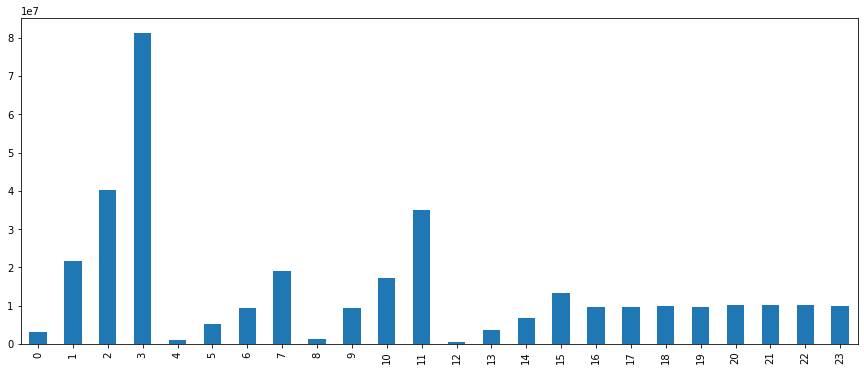

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

C:\Users\danie\AppData\Local\Temp/ipykernel_25008/3467378951.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


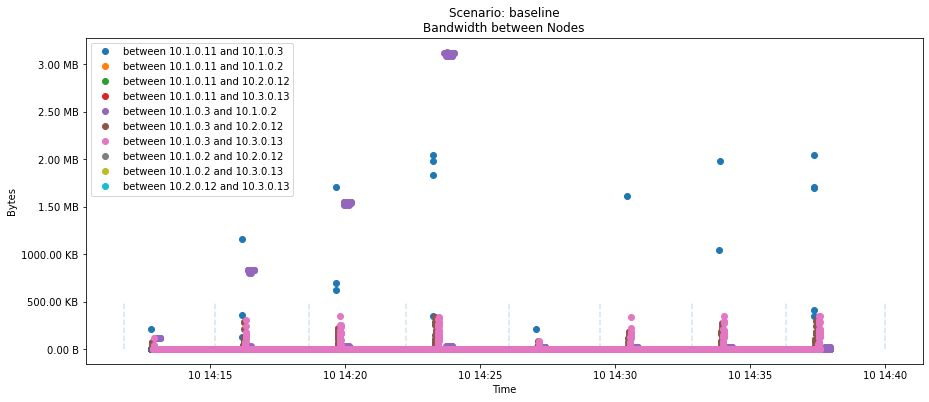

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="baseline"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

C:\Users\danie\AppData\Local\Temp/ipykernel_25008/4238307838.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


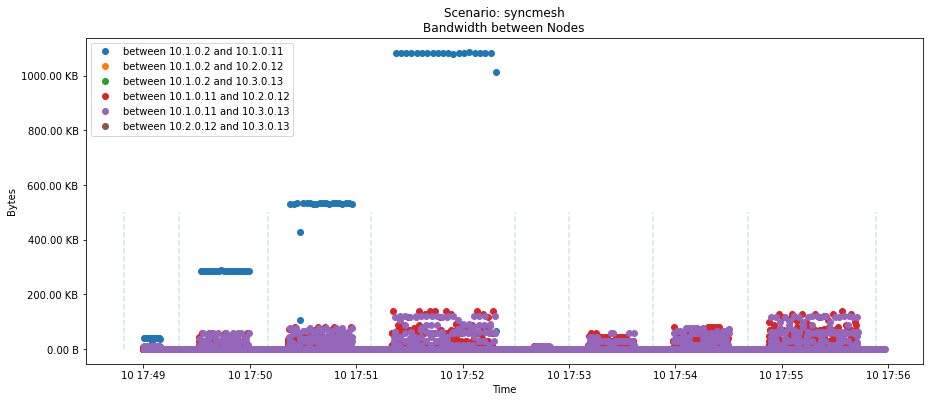

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="syncmesh"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

C:\Users\danie\AppData\Local\Temp/ipykernel_25008/1540596556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


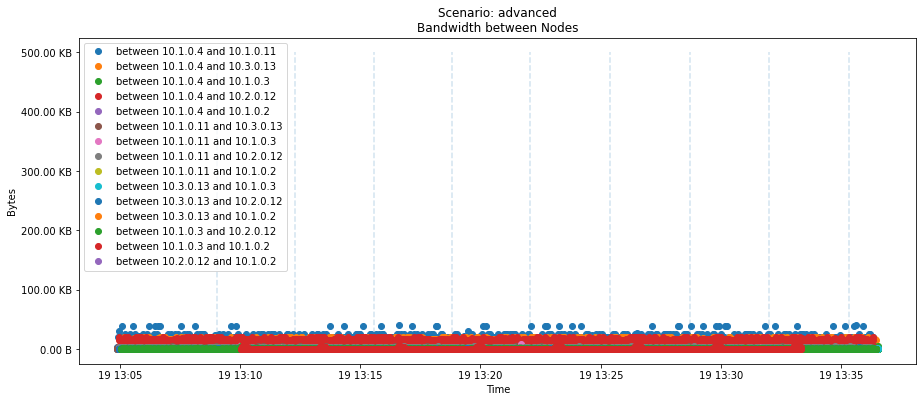

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="advanced"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

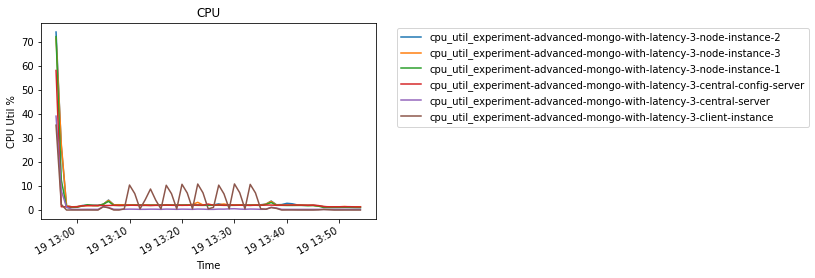

,cpu_util_experiment-advanced-mongo-with-latency-3-node-instance-2,io_read_experiment-advanced-mongo-with-latency-3-node-instance-2,io_write_experiment-advanced-mongo-with-latency-3-node-instance-2,iops_read_experiment-advanced-mongo-with-latency-3-node-instance-2,iops_write_experiment-advanced-mongo-with-latency-3-node-instance-2,cpu_util_experiment-advanced-mongo-with-latency-3-node-instance-3,io_read_experiment-advanced-mongo-with-latency-3-node-instance-3,io_write_experiment-advanced-mongo-with-latency-3-node-instance-3,iops_read_experiment-advanced-mongo-with-latency-3-node-instance-3,iops_write_experiment-advanced-mongo-with-latency-3-node-instance-3,...,cpu_util_experiment-advanced-mongo-with-latency-3-central-server,io_read_experiment-advanced-mongo-with-latency-3-central-server,io_write_experiment-advanced-mongo-with-latency-3-central-server,iops_read_experiment-advanced-mongo-with-latency-3-central-server,iops_write_experiment-advanced-mongo-with-latency-3-central-server,cpu_util_experiment-advanced-mongo-with-latency-3-client-instance,io_read_experiment-advanced-mongo-with-latency-3-client-instance,io_write_experiment-advanced-mongo-with-latency-3-client-instance,iops_read_experiment-advanced-mongo-with-latency-3-client-instance,iops_write_experiment-advanced-mongo-with-latency-3-client-instance
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-19 13:54:00,0.014244,0,1027583,0,63,0.014959,0,1004529,0,66,...,0.003945,0,361815,0,26,0.001182,0,0,0,0
2021-09-19 13:53:00,0.014378,0,1175885,0,84,0.014035,0,1168409,0,83,...,0.003882,0,412516,0,34,0.001178,0,4036,0,1
2021-09-19 13:52:00,0.014445,0,1150285,0,76,0.014184,0,1111019,0,72,...,0.003940,0,373642,0,28,0.001233,0,16203,0,3
2021-09-19 13:51:00,0.014730,24217,1097010,1,70,0.015763,0,1090184,0,70,...,0.004044,0,360721,0,26,0.001219,0,241,0,0
2021-09-19 13:50:00,0.014533,8551,1044125,0,64,0.014784,0,1050608,0,69,...,0.003969,0,368457,0,34,0.001154,0,0,0,0
2021-09-19 13:49:00,0.014505,0,1052305,0,71,0.014788,0,1104042,0,77,...,0.003947,0,420709,0,29,0.001153,0,0,0,0
2021-09-19 13:48:00,0.014397,0,1069958,0,66,0.014195,0,1077952,0,73,...,0.003923,0,353801,0,28,0.002288,0,108963,0,21
2021-09-19 13:47:00,0.015396,0,1539314,0,104,0.015394,0,1402929,0,94,...,0.004010,0,424346,0,34,0.003364,363212,368877,35,48
2021-09-19 13:46:00,0.018643,0,1697896,0,118,0.018105,0,1717588,0,120,...,0.003881,0,357899,0,23,0.001813,5428,25667,1,5


In [ ]:
df = pd.read_csv("data/20210919-15/monitoring_experiment-advanced-mongo-with-latency-3.csv")
columns = df.columns
df.set_index('timestamp', inplace=True)
# df = df.loc[str(pd.to_datetime("2021-09-15T09:10:00")):str(pd.to_datetime("2021-09-15T08:37:00"))]
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("cpu_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()
df